In [2]:
pip install torchbnn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def compute_kl_loss(layer):
    mu = layer.weight_mu
    rho = layer.weight_rho
    sigma = torch.log1p(torch.exp(rho))  # softplus to ensure positivity

    kl = (
        -torch.log(sigma) + 0.5 * (sigma**2 + mu**2) - 0.5
    ).sum()

    if layer.bias_mu is not None:
        mu = layer.bias_mu
        rho = layer.bias_rho
        sigma = torch.log1p(torch.exp(rho))
        kl += (
            -torch.log(sigma) + 0.5 * (sigma**2 + mu**2) - 0.5
        ).sum()

    return kl


In [17]:


# 데이터 생성
x = torch.linspace(-5, 5, 100).reshape(-1, 1)
y = torch.sin(x) + 0.1 * torch.randn_like(x)

# 테스트용 x
x_test = torch.linspace(-6, 6, 100).reshape(-1, 1)

# 모델 정의 (Bayesian Layer 포함)
class BayesianMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.bfc1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=64)
        self.relu = nn.ReLU()
        self.bfc2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=1)

    def forward(self, x):
        x = self.relu(self.bfc1(x))
        return self.bfc2(x)

model = BayesianMLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 훈련
epochs = 20000

# BKLLoss 객체 생성 (클래스 수준으로 KL 모음)
klloss = bnn.BKLLoss(reduction='sum', last_layer_only=False)

mse_losses = []
kl_losses = []
total_losses = []


for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x)
    mse_loss = criterion(outputs, y)

    kl_loss = klloss(model)  # torchbnn BKLLoss 객체
    loss = mse_loss + 0.01 * kl_loss

    loss.backward()
    optimizer.step()

    # ✅ 기록
    mse_losses.append(mse_loss.item())
    kl_losses.append(kl_loss.item())
    total_losses.append(loss.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, KL: {kl_loss.item():.4f}")



Epoch 0, Loss: 18.6232, KL: 1773.7629
Epoch 200, Loss: 0.5519, KL: 1.8558
Epoch 400, Loss: 0.6231, KL: 1.6345
Epoch 600, Loss: 0.5512, KL: 1.8557
Epoch 800, Loss: 0.5545, KL: 2.1420
Epoch 1000, Loss: 0.5580, KL: 2.5626
Epoch 1200, Loss: 0.7210, KL: 2.0938
Epoch 1400, Loss: 0.6461, KL: 2.4247
Epoch 1600, Loss: 0.5800, KL: 3.5160
Epoch 1800, Loss: 0.5822, KL: 3.2467
Epoch 2000, Loss: 0.5625, KL: 2.5677
Epoch 2200, Loss: 0.6428, KL: 2.6047
Epoch 2400, Loss: 0.5802, KL: 3.4636
Epoch 2600, Loss: 0.5403, KL: 2.4893
Epoch 2800, Loss: 0.6828, KL: 3.3127
Epoch 3000, Loss: 0.6097, KL: 3.1657
Epoch 3200, Loss: 0.6177, KL: 2.8075
Epoch 3400, Loss: 0.5643, KL: 2.4660
Epoch 3600, Loss: 0.5669, KL: 4.3046
Epoch 3800, Loss: 0.6655, KL: 4.4100
Epoch 4000, Loss: 0.6138, KL: 3.5784
Epoch 4200, Loss: 0.5564, KL: 3.1530
Epoch 4400, Loss: 0.5973, KL: 3.7653
Epoch 4600, Loss: 0.5749, KL: 2.6008
Epoch 4800, Loss: 0.6354, KL: 2.1319
Epoch 5000, Loss: 0.5931, KL: 4.0524
Epoch 5200, Loss: 0.6278, KL: 3.0730
Epoc

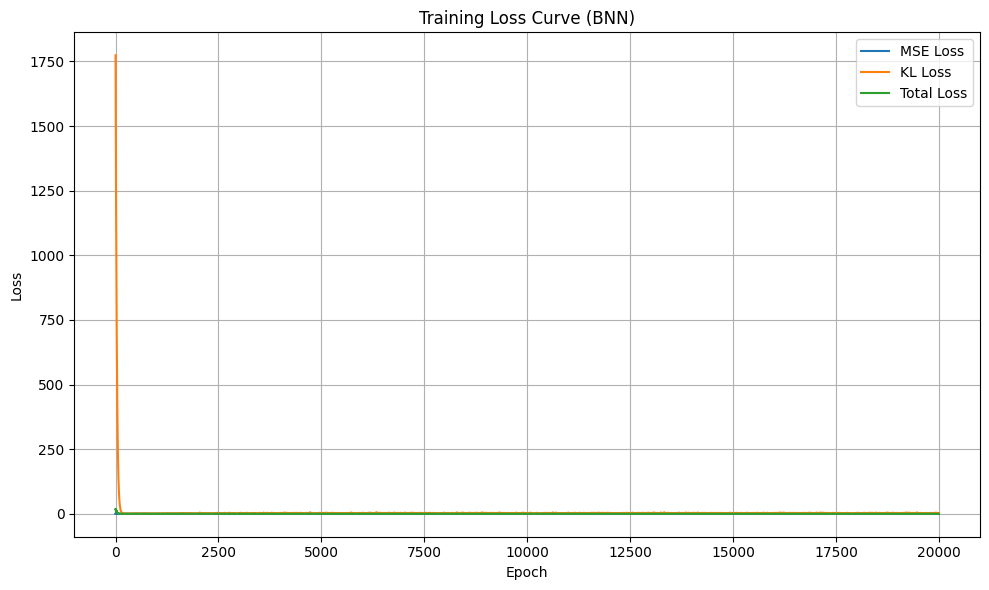

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(mse_losses, label='MSE Loss')
plt.plot(kl_losses, label='KL Loss')
plt.plot(total_losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve (BNN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

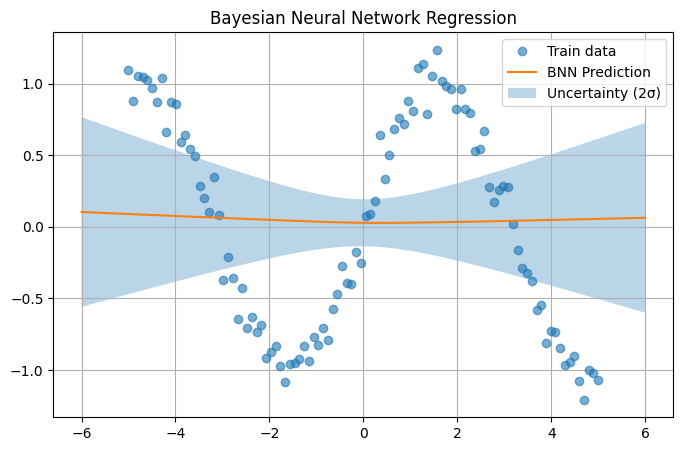

In [19]:
# 추론: 여러 번 샘플링하여 평균과 불확실성 추정
model.eval()
preds = []
for _ in range(2000):
    with torch.no_grad():
        pred = model(x_test)
        preds.append(pred.numpy())

preds = np.array(preds)
mean = preds.mean(axis=0).squeeze()
std = preds.std(axis=0).squeeze()

# 결과 시각화
plt.figure(figsize=(8, 5))
plt.plot(x.numpy(), y.numpy(), 'o', label="Train data", alpha=0.6)
plt.plot(x_test.numpy(), mean, label="BNN Prediction")
plt.fill_between(x_test.squeeze().numpy(), mean - 2*std, mean + 2*std, alpha=0.3, label="Uncertainty (2σ)")
plt.legend()
plt.grid()
plt.title("Bayesian Neural Network Regression")
plt.show()
